# Stimulation example

This notebook will give you a simple example of how to construct a stimulus and apply it as an input current to the excitatory population of the `aln` model.

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] in ["examples", "dev"]:
    os.chdir('..')
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

In [3]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt
    
import numpy as np
import scipy

# Let's import the aln model
from neurolib.models.aln import ALNModel

# Some useful functions are provided here
import neurolib.utils.functions as func
from neurolib.utils.stimulus import construct_stimulus

First, we initialize a single node.

In [9]:
model = ALNModel()
model.params['duration'] = 5 * 1000
model.params['sigma_ou'] = 0.2 # we add some noise

We can construct a simple stimulus using the function `stimulus.construct_stimulus`:

In [10]:
stimulus = construct_stimulus("rect", duration=model.params.duration, dt=model.params.dt, stim_amp=1.0, stim_freq=1)

In [11]:
stimulus = construct_stimulus("ac", duration=model.params.duration, dt=model.params.dt, stim_amp=1.0, stim_freq=1)

The stimulus is then set as an input current parameter to the model. The parameter that models a current that goes to the excitatory population is called `ext_exc_current`. For the inhibitory population, we can use `ext_inh_current`. We can also set a firing rate input, that will then be integrated over the synapses using the parameter `model.params['ext_exc_rate']`.

In [12]:
model.params['ext_exc_current'] = stimulus
model.run()

When we plot the timeseries, we can see that the oscillatory activity locks to the stimulus.

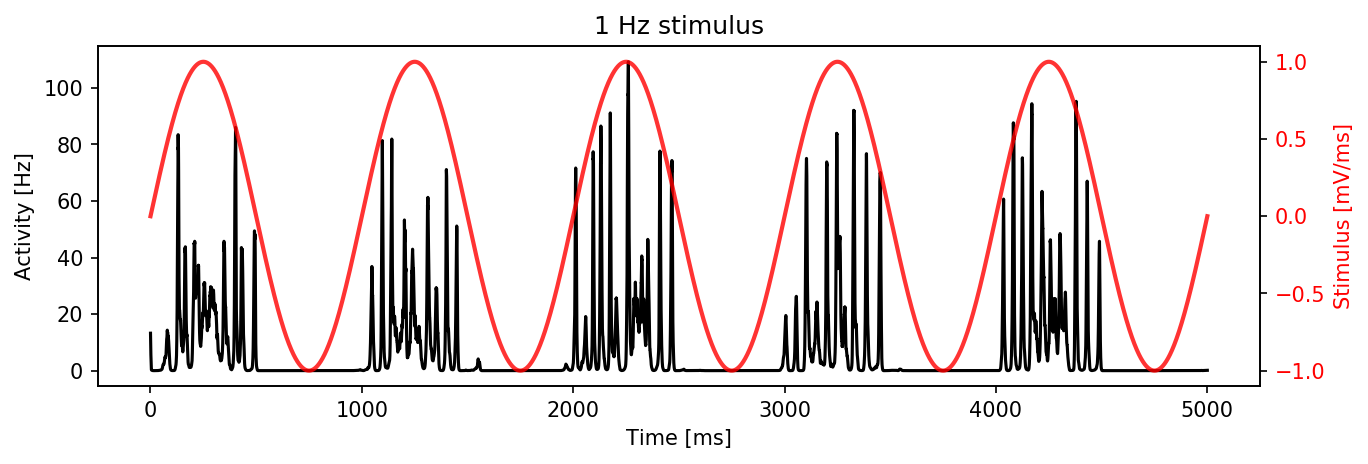

In [13]:
plt.figure(figsize=(10, 3), dpi=150)
plt.title("1 Hz stimulus")
ax1 = plt.gca()
ax1.plot(model.t, model.output.T, c="k")
ax2 = plt.gca().twinx()
ax2.plot(model.t, stimulus, lw=2, c="r", alpha=0.8)
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Activity [Hz]")
ax2.set_ylabel("Stimulus [mV/ms]", color='r')
ax2.set_ylabel("Stimulus [mV/ms]", color='r')
ax2.tick_params(axis='y', labelcolor='r')

## Brain network stimulation

In [5]:
from neurolib.utils.loadData import Dataset
ds = Dataset("hcp")

In [6]:
model = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat)

# we chose a parameterization in which the brain network oscillates slowly 
# between up- and down-states

model.params["mue_ext_mean"] = 2.56
model.params["mui_ext_mean"] = 3.52
model.params["b"] = 4.67
model.params["tauA"] = 1522.68
model.params["sigma_ou"] = 0.40

model.params['duration'] = 0.2*60*1000 

In [8]:
def plot_output_and_spectrum(model, individual=False, vertical_mark=None):
    """A simple plotting function for the timeseries
    and the power spectrum of the activity.
    """
    fig, axs = plt.subplots(1, 2, figsize = (8, 2), dpi=150, gridspec_kw={"width_ratios" : [2, 1]})
    axs[0].plot(model.t, model.output.T, lw=1);
    axs[0].set_xlabel("Time [ms]")
    axs[0].set_ylabel("Activity [Hz]")
    
    frs, powers = func.getMeanPowerSpectrum(model.output, dt=model.params.dt)
    axs[1].plot(frs, powers, c='k')
    
    if individual:
        for o in model.output:
            frs, powers = func.getPowerSpectrum(o, dt=model.params.dt)
            axs[1].plot(frs, powers)
        

    axs[1].set_xlabel("Frequency [Hz]")
    axs[1].set_ylabel("Power")
    
    plt.show()

### Without stimulation

In [7]:
model.run(chunkwise=True)

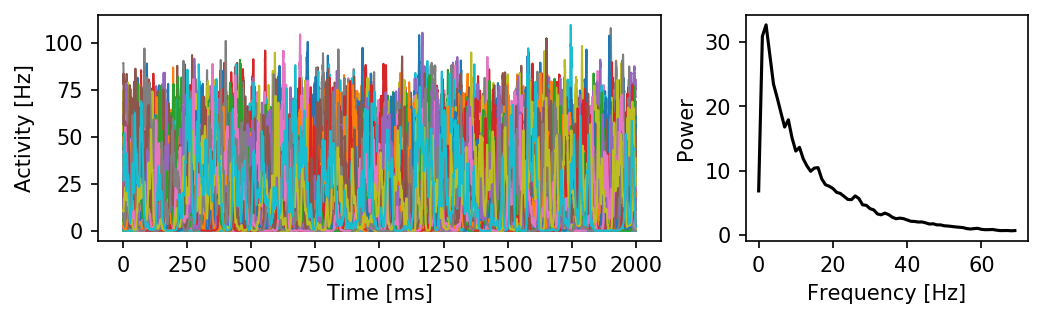

In [9]:
plot_output_and_spectrum(model)

### Constructing a stimulus

`neurolib` helps you to create a few basic stimuli out of the box using the function `stimulus.construct_stimulus()`.

In [10]:
# construct a stimulus
ac_stimulus = construct_stimulus(stim="ac", stim_freq = 25, duration=model.params.duration, dt=model.params.dt)

# this stimulus is 1-dimensional. neurolib will threfore automatically apply it to *all nodes*.
model.params['ext_exc_current'] = ac_stimulus * 5.0 

In [11]:
model.run(chunkwise=True)

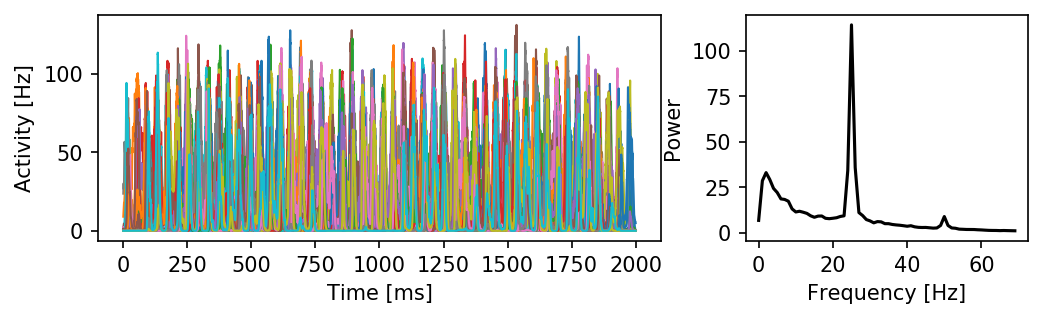

In [12]:
plot_output_and_spectrum(model)

### Focal stimulation

In the previous example, the stimulus was applied to *all nodes* simultaneously. We can also apply stimulation to a specific set of nodes.

In [16]:
# this stimulus is 1-dimensional
ac_stimulus = construct_stimulus(stim="ac", stim_freq = 25, duration=model.params.duration, dt=model.params.dt)

# let's make a N-dimensional stimulus vector out of it, by copying and pasting each entry N times
ac_stimulus = np.tile(ac_stimulus.T, (model.params.N, 1))

# We set the input to a bunch of nodes to zero. 
# This will have the effect that only nodes from 0 to 4 will be sitmulated!
ac_stimulus[5:, :] = 0

# multiply the stimulus amplitude
model.params['ext_exc_current'] = ac_stimulus * 5.0 

In [17]:
model.run(chunkwise=True)

We can see that the spectrum has a peak at the frequency we stimulated with, but only in a subset of nodes (where we stimulated).

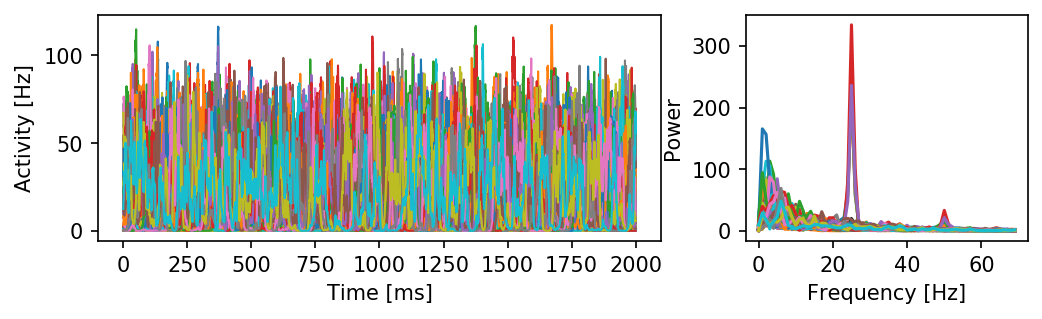

In [19]:
plot_output_and_spectrum(model, individual=True)